In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))
suppressMessages(library(parallel))
suppressMessages(library(ggrepel))

In [2]:
set.seed(42)
getwd()

addArchRThreads(threads = parallel::detectCores() - 2)
addArchRGenome("hg38")

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Fibroblast/code"

Setting default number of Parallel threads to 126.

Setting default genome to Hg38.



In [3]:
## subset atac project
proj <- loadArchRProject("../data/snATAC_SCARA5_Myofib", showLogo = FALSE)

Successfully loaded ArchRProject!



ArchR logging to : ArchRLogs/ArchR-plotTrajectory-e3068495efa38-Date-2022-01-26_Time-13-39-38.log
If there is an issue, please report to github with logFile!

Plotting

Plotting Trajectory

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectory-e3068495efa38-Date-2022-01-26_Time-13-39-38.log



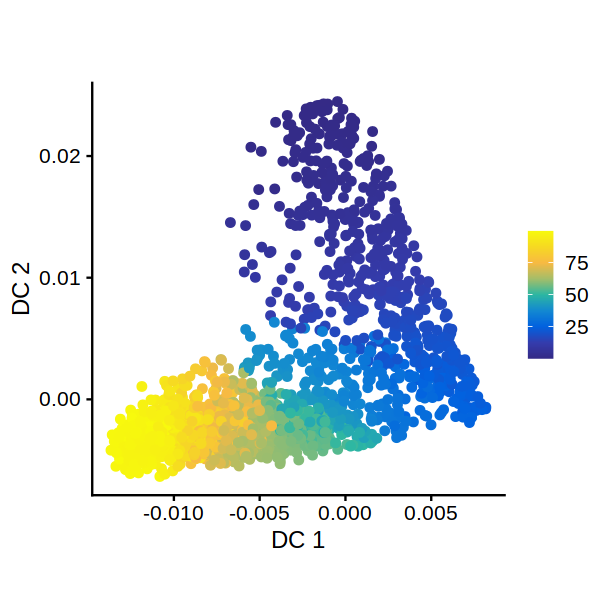

In [4]:
p <- plotTrajectory(proj, trajectory = "SCARA5_Myofib_dm", 
                    colorBy = "cellColData",
                    continuousSet = "blueYellow",
                    name = "SCARA5_Myofib_dm",
                    embedding = "dm",
                    plotAs = "points",
                    rastr = FALSE,
                    addArrow = FALSE,
                    size = 2)

p1 <- p[[1]] + 
    theme_cowplot() +
    xlab("DC 1") + ylab("DC 2") +
    ggtitle("")

options(repr.plot.width = 5, repr.plot.height = 5)

p1

Creating Trajectory Group Matrix..

Smoothing...

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-e3068324d5fc8-Date-2022-01-26_Time-13-39-46.log
If there is an issue, please report to github with logFile!

useSeqnames is NULL or greater than 1 with a Sparse.Assays.Matrix trajectory input.

2022-01-26 13:39:46 : 

force=FALSE thus continuing with subsetting useSeqnames = z

2022-01-26 13:39:46 : 

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-e3068324d5fc8-Date-2022-01-26_Time-13-39-46.log



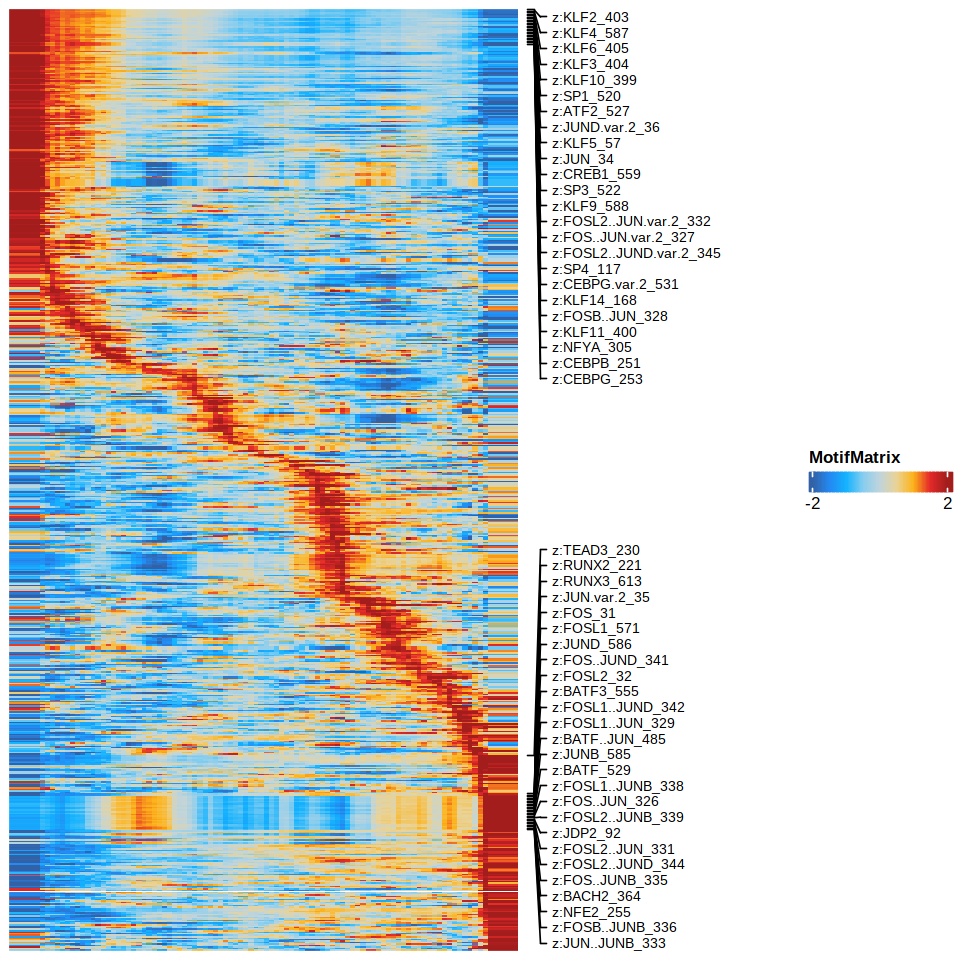

In [5]:
trajMM  <- getTrajectory(ArchRProj = proj,
                         name = "SCARA5_Myofib_dm",
                         useMatrix = "MotifMatrix",
                         log2Norm = FALSE,
                         scaleTo = NULL,
                        smoothWindow = 11)

trajMM <- trajMM[!grepl("deviations", rownames(trajMM)), ]

p1 <- plotTrajectoryHeatmap(trajMM, 
                            varCutOff = 0,
                            pal = paletteContinuous(set = "solarExtra"),
                            limits = c(-2, 2))

options(repr.plot.height = 8, repr.plot.width = 8)

p1

Creating Trajectory Group Matrix..

Smoothing...

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-e30685eda81d-Date-2022-01-26_Time-13-39-59.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-e30685eda81d-Date-2022-01-26_Time-13-39-59.log



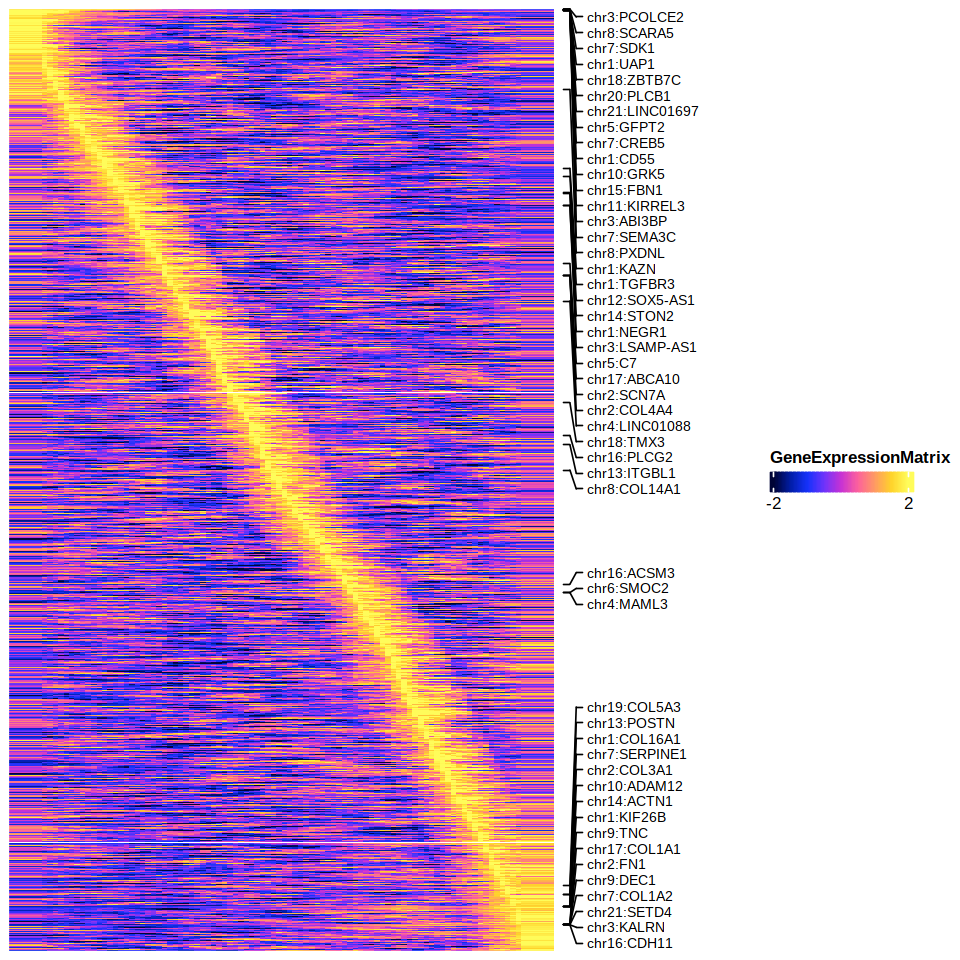

In [6]:
trajGEX <- getTrajectory(ArchRProj = proj,
                         name = "SCARA5_Myofib_dm",
                         useMatrix = "GeneExpressionMatrix",
                         log2Norm = TRUE,
                        smoothWindow = 11)

p2 <- plotTrajectoryHeatmap(trajGEX,
                        varCutOff = 0.5,
                        pal = paletteContinuous(set = "horizonExtra"),
                        limits = c(-2, 2))
p2

In [7]:
options(repr.plot.height = 6, repr.plot.width = 12)

correlation_analysis <- function(trajMM, trajGEX, varCutOff1 = 0, varCutOff2 = 0,
                                 cor_threshold = 0.1){
    
    corMM_GEX <- correlateTrajectories(trajMM, trajGEX,
                                   varCutOff1 = varCutOff1,
                                   varCutOff2 = varCutOff2,
                                   corCutOff = 0)

    df <- as.data.frame(corMM_GEX[[1]])
    df <- df[!grepl("-AS", df$name2), ]
    df <- df[df$Correlation > cor_threshold, ]

    ## plot correlation
    p <- ggplot(data = df, aes(x = reorder(matchname1, -Correlation), y = Correlation)) +
        geom_point() +
        geom_text_repel(aes(label = matchname1)) +
        xlab("") + ggtitle(glue::glue("Number of TFs: {nrow(df)}")) +
        theme_cowplot() +
        theme(axis.ticks.x = element_blank(),
             axis.text.x = element_blank())
    
    print(p)

    df <- df[!duplicated(df$matchname1), ]
    
    trajMM2 <- trajMM[df$name1, ]
    trajGEX2 <- trajGEX[df$name2, ]

    trajCombined <- trajMM2

    assay(trajCombined, withDimnames=FALSE) <- t(apply(assay(trajGEX2), 1, scale)) + 
        t(apply(assay(trajMM2), 1, scale))

    combinedMat <- plotTrajectoryHeatmap(trajCombined,
                                         returnMat = TRUE,
                                         varCutOff = 0)

    rowOrder <- match(rownames(combinedMat), rownames(trajMM2))
    
    ht1 <- plotTrajectoryHeatmap(trajMM2,
                                 pal = paletteContinuous(set = "solarExtra"),
                                 varCutOff = 0,
                                 rowOrder = rowOrder,
                                 limits = c(-2, 2),
                                 labelRows = TRUE,
                                labelTop = 100)

    ht2 <- plotTrajectoryHeatmap(trajGEX2,
                                 pal = paletteContinuous(set = "horizonExtra"),
                                 varCutOff = 0,
                                 rowOrder = rowOrder,
                                 limits = c(-2, 2),
                                 labelRows = TRUE,
                                labelTop = 100)


    options(repr.plot.height = 8, repr.plot.width = 10)

    draw(ht1 + ht2)
    
    saveRDS(trajMM2, "../data/snATAC_SCARA5_Myofib/trajMM2.rds")
    saveRDS(trajGEX2, "../data/snATAC_SCARA5_Myofib/trajGEX2.rds")
    saveRDS(rowOrder, "../data/snATAC_SCARA5_Myofib/rowOrder.rds")

    return(df)

}

ArchR logging to : ArchRLogs/ArchR-correlateTrajectories-e30681441102c-Date-2022-01-26_Time-13-40-08.log
If there is an issue, please report to github with logFile!

Found 137 Correlated Pairings!

2022-01-26 13:40:10 : 

Warning message:
“ggrepel: 6 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-e306865b25e69-Date-2022-01-26_Time-13-40-11.log
If there is an issue, please report to github with logFile!

useSeqnames is NULL or greater than 1 with a Sparse.Assays.Matrix trajectory input.

2022-01-26 13:40:11 : 

force=FALSE thus continuing with subsetting useSeqnames = z

2022-01-26 13:40:11 : 

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-e306865b25e69-Date-2022-01-26_Time-13-40-11.log

ArchR logging to : ArchRLogs/ArchR-plotTr

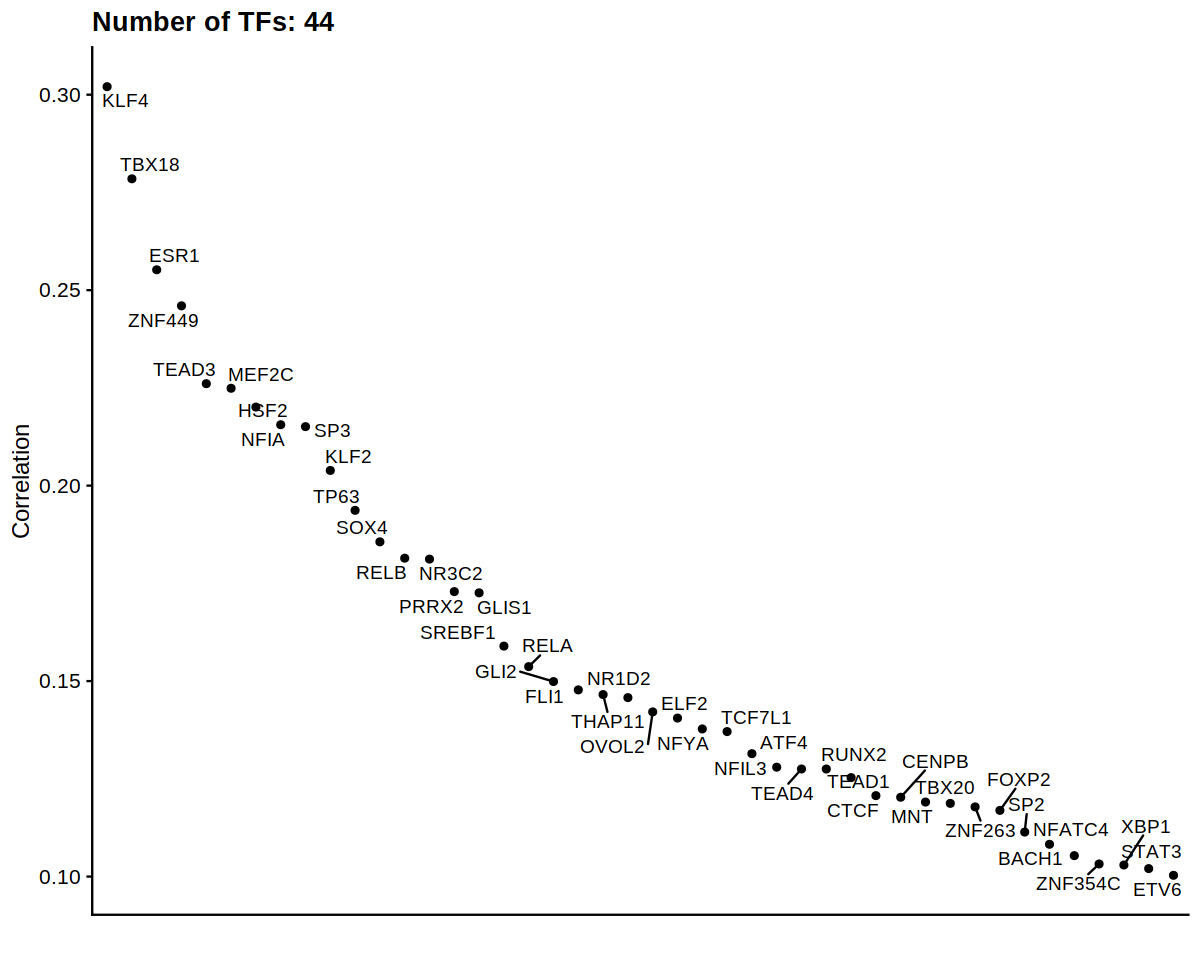

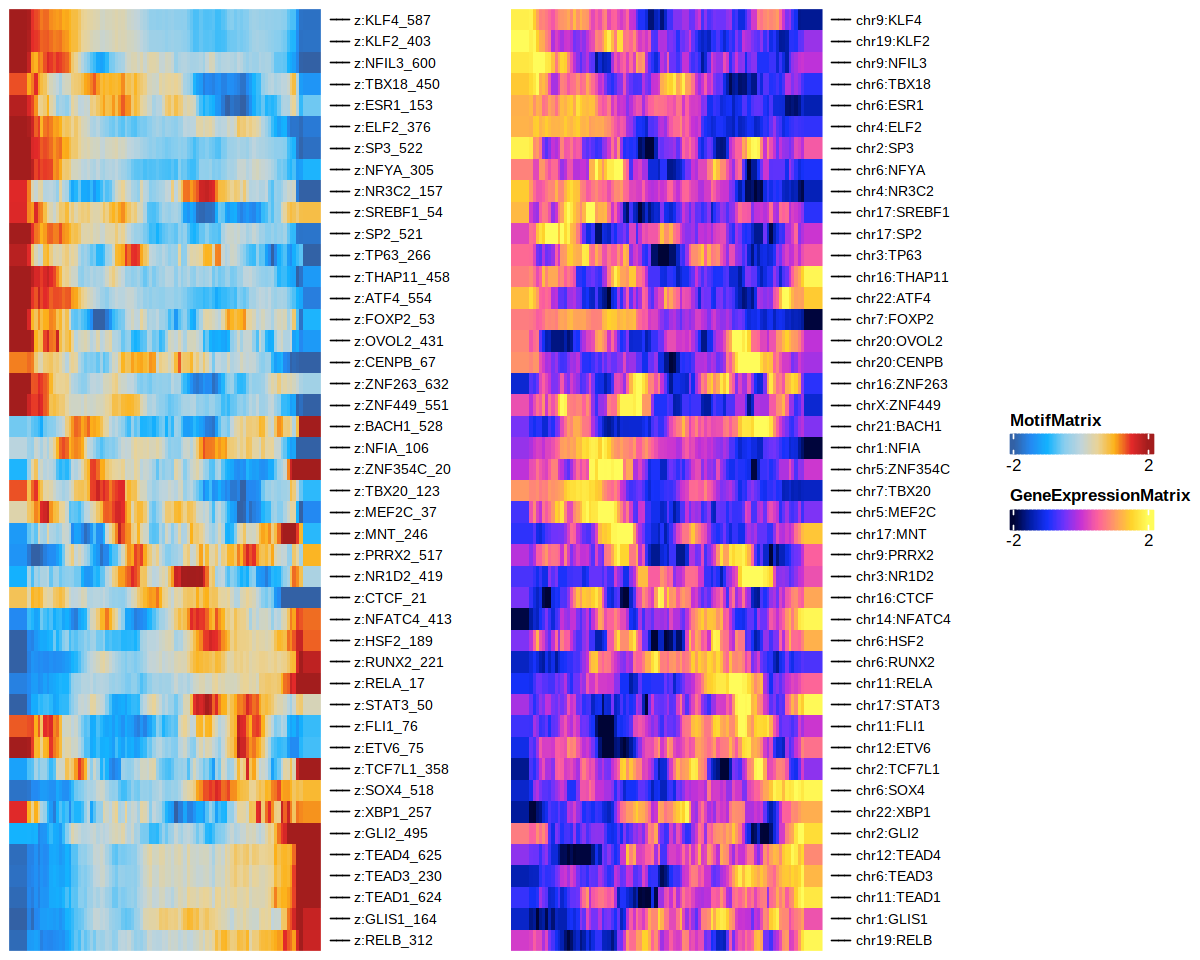

In [8]:
df1 <- correlation_analysis(trajMM, trajGEX, cor_threshold = 0.1, varCutOff1 = 0, varCutOff2 = 0.5)
write.csv(df1, "../data/snATAC_SCARA5_Myofib/sel_tf_by_expression.csv")

In [9]:
# proj <- addHarmony(
#     ArchRProj = proj,
#     reducedDims = "IterativeLSI",
#     name = "Harmony_v2",
#     groupBy = "Sample",
#     force = TRUE
# )

In [10]:
# proj <- addImputeWeights(proj, reducedDims = "Harmony_v2")

In [11]:
# if(!dir.exists("../data/snATAC_SCARA5_Myofib/SelectedTFByExpression"))
# {
#     dir.create("../data/snATAC_SCARA5_Myofib/SelectedTFByExpression")

# }

# df <- read.csv("../data/snATAC_SCARA5_Myofib/sel_tf_by_expression.csv", row.names = 1)

# for(i in 1:nrow(df)){
#     tf_name = df$name1[[i]]
#     gene_name = df$matchname1[[i]]
    
    
#     p1 <- plotEmbedding(
#     ArchRProj = proj, 
#     colorBy = "MotifMatrix", 
#     log2Norm = TRUE,
#     name = tf_name, 
#     embedding = "dm",
#     quantCut = c(0.1, 0.95),
#     imputeWeights = getImputeWeights(proj),
#      plotAs = "points",
#     rastr = FALSE,
#     size = 1.5,
#     pal = paletteContinuous(set = "solarExtra")
# ) + theme_cowplot() + theme(legend.title = element_blank()) + 
#     ggtitle(glue::glue("TF activity: {gene_name}"))

# p2 <- plotEmbedding(
#     ArchRProj = proj, 
#     colorBy = "GeneExpressionMatrix", 
#     log2Norm = FALSE,
#     name = gene_name, 
#     embedding = "dm",
#     quantCut = c(0.05, 0.95),
#     imputeWeights = getImputeWeights(proj),
#      plotAs = "points",
#     rastr = FALSE,
#     size = 1.5,
#     pal = paletteContinuous(set = "horizonExtra")
# )+ theme_cowplot()+ theme(legend.title = element_blank())+ 
#     ggtitle(glue::glue("TF expression: {gene_name}"))
    
#     p3 <- plotTrajectory(proj, 
#                          trajectory = "SCARA5_Myofib_dm", 
#                          colorBy = "MotifMatrix", 
#                          name = tf_name, 
#                          continuousSet = "solarExtra",
#                         plotAs = "points",
#     rastr = FALSE,
#     size = 1.5)
    
#     p3 <- p3[[2]] + theme_cowplot()
    
#     p4 <- plotTrajectory(proj, 
#                          trajectory = "SCARA5_Myofib_dm", 
#                          colorBy = "GeneExpressionMatrix", 
#                          name = gene_name, 
#                          continuousSet = "horizonExtra",
#                         plotAs = "points",
#     rastr = FALSE,
#     size = 1.5)
    
#     p4 <- p4[[2]] + theme_cowplot()
    
#     options(repr.plot.height = 10, repr.plot.width = 10)
    
#     p <- patchwork::wrap_plots(list(p1, p2, p3, p4), nrow = 2)
# #    print(p)
    
#     pdf(glue::glue("../data/snATAC_SCARA5_Myofib/SelectedTFByExpression/{gene_name}.pdf"), 
#         height = 10, width = 10)
#     print(p)
#     dev.off()
# }

In [12]:
# if(!dir.exists("../data/snATAC_SCARA5_Myofib/SelectedTFByAccessibility"))
# {
#     dir.create("../data/snATAC_SCARA5_Myofib/SelectedTFByAccessibility")

# }

# df <- read.csv("../data/snATAC_SCARA5_Myofib/sel_tf_by_accessibility.csv", row.names = 1)

# for(i in 1:nrow(df)){
#     tf_name = df$name1[[i]]
#     gene_name = df$matchname1[[i]]
    
    
#     p1 <- plotEmbedding(
#     ArchRProj = proj, 
#     colorBy = "MotifMatrix", 
#     log2Norm = TRUE,
#     name = tf_name, 
#     embedding = "dm",
#     quantCut = c(0.1, 0.95),
#     imputeWeights = getImputeWeights(proj),
#      plotAs = "points",
#     rastr = FALSE,
#     size = 1.5,
#     pal = paletteContinuous(set = "solarExtra")
# ) + theme_cowplot() + theme(legend.title = element_blank()) + 
#     ggtitle(glue::glue("TF activity: {gene_name}"))

# p2 <- plotEmbedding(
#     ArchRProj = proj, 
#     colorBy = "GeneScoreMatrix", 
#     log2Norm = FALSE,
#     name = gene_name, 
#     embedding = "dm",
#     quantCut = c(0.05, 0.95),
#     imputeWeights = getImputeWeights(proj),
#      plotAs = "points",
#     rastr = FALSE,
#     size = 1.5,
#     pal = paletteContinuous(set = "horizonExtra")
# )+ theme_cowplot()+ theme(legend.title = element_blank())+ 
#     ggtitle(glue::glue("TF accessibility: {gene_name}"))
    
#     p3 <- plotTrajectory(proj, 
#                          trajectory = "SCARA5_Myofib_dm", 
#                          colorBy = "MotifMatrix", 
#                          name = tf_name, 
#                          continuousSet = "solarExtra",
#                         plotAs = "points",
#     rastr = FALSE,
#     size = 1.5)
    
#     p3 <- p3[[2]] + theme_cowplot()
    
#     p4 <- plotTrajectory(proj, 
#                          trajectory = "SCARA5_Myofib_dm", 
#                          colorBy = "GeneScoreMatrix", 
#                          name = gene_name, 
#                          continuousSet = "horizonExtra",
#                         plotAs = "points",
#     rastr = FALSE,
#     size = 1.5)
    
#     p4 <- p4[[2]] + theme_cowplot()
    
#     options(repr.plot.height = 10, repr.plot.width = 10)
    
#     p <- patchwork::wrap_plots(list(p1, p2, p3, p4), nrow = 2)
#     #print(p)
    
#     pdf(glue::glue("../data/snATAC_SCARA5_Myofib/SelectedTFByAccessibility/{gene_name}.pdf"), 
#         height = 10, width = 10)
#     print(p)
#     dev.off()
# }

In [13]:
saveArchRProject(ArchRProj = proj, load = FALSE)

Saving ArchRProject...



In [14]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 8

Matrix products: default
BLAS/LAPACK: /home/rs619065/miniconda3/envs/r-4.1/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] circlize_0.4.13             ComplexHeatmap_2.10.0      
 [3] ggrepel_0.9.1               phateR_1.0.7               
 [5] Ipaper_0.1.8                ggpubr_0.4.0               
 [7] Nebulosa_1.4.0              patchwork_1.1.1            
 [9] cowplot_1.1.1         